## Analiza czasowo-częstotliwościowa sygnału

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('data/dane_ascii.csv')
df

,X,Y,Z
0,48,144,-200
1,66,134,-218
2,50,148,-210
3,52,150,-204
4,52,150,-192
...,...,...,...
29511,52,150,-204
29512,52,152,-184
29513,50,152,-178
29514,54,152,-196


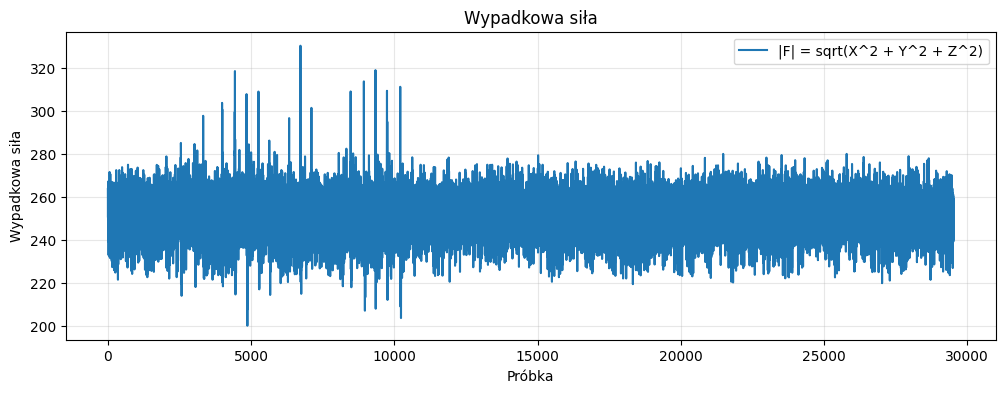

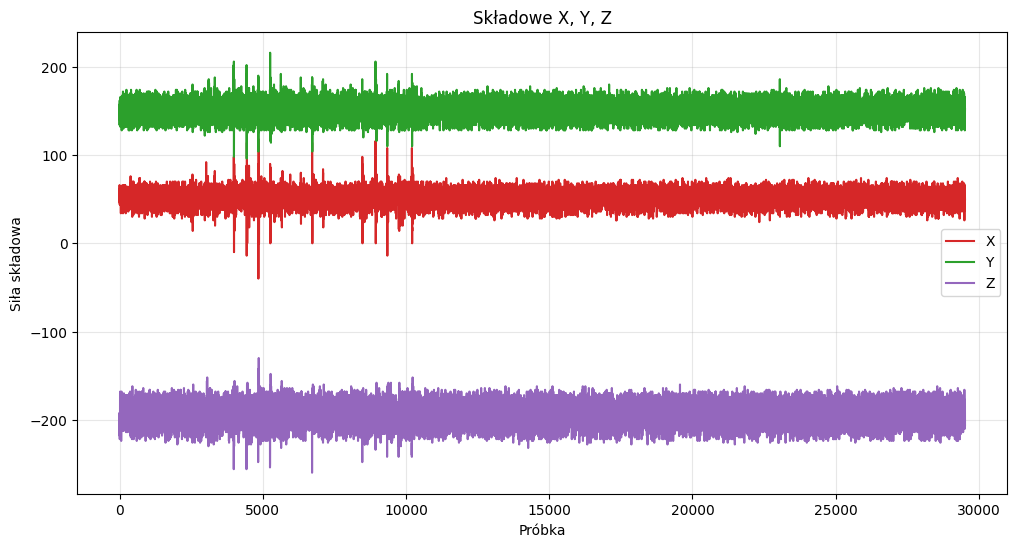

In [12]:
import numpy as np
import matplotlib.pyplot as plt

df['R'] = np.sqrt(df['X']**2 + df['Y']**2 + df['Z']**2)

# Wykres 1: wypadkowa
plt.figure(figsize=(12, 4))
plt.plot(df['R'].values, label='|F| = sqrt(X^2 + Y^2 + Z^2)', color='#1f77b4')
plt.xlabel('Próbka'); plt.ylabel('Wypadkowa siła'); plt.title('Wypadkowa siła')
plt.grid(True, alpha=0.3); plt.legend(); plt.show()

# Wykres 2: składowe X, Y, Z
plt.figure(figsize=(12, 6))
plt.plot(df['X'].values, label='X', color='#d62728')
plt.plot(df['Y'].values, label='Y', color='#2ca02c')
plt.plot(df['Z'].values, label='Z', color='#9467bd')
plt.xlabel('Próbka'); plt.ylabel('Siła składowa'); plt.title('Składowe X, Y, Z')
plt.grid(True, alpha=0.3); plt.legend(); plt.show()
